In [1]:
import pandas as pd
import numpy as np 

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_curve

from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from CustomTransformers import *
from Evaluation import *
from ClassifierAnalyzer import *

# Review Previous Work

### Class Definitions

In [2]:
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        terms_regex = '|'.join(terms)
        filtered_data = (self.data.filter(self.data['term'].rlike(terms_regex)))

        if hashtags != None:
            hashtags_regex = '|'.join(hashtags)
            filtered_data = filtered_data.union(self.data.filter(self.data['hashtag'].rlike(hashtags_regex)))

        if users != None:
            users_regex = '|'.join(users)
            filtered_data = filtered_data.union(self.data.filter(self.data['from_user'].rlike(users_regex)))

        if locs != None:
            locs_regex = '|'.join(locs)
            filtered_data = filtered_data.union(self.data.filter(self.data['location'].rlike(locs_regex)))

        if mentions != None:
            mentions_regex = '|'.join(mentions)
            filtered_data = filtered_data.union(self.data.filter(self.data['mention'].rlike(mentions_regex)))

        return filtered_data.dropDuplicates().cache()
    
    
class DataPreprocessor():
    def __init__(self, data):
        self.data = data
        self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label")).distinct().cache()
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()

        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_test_time = pd_ordered_hashtag_set.iloc[train_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_test_time)
        test_set = labled_data.where(col("create_time") > train_test_time)
        
        if balance_data == True:
            training_set = training_set.sampleBy("label", fractions={0.0: 0.001, 1.0: 1}, seed=seed) 
        
        return training_set, test_set

In [3]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory, frac=0.01, seed=123)

Revise TestFramework class for easier testing across topics:

In [4]:
class TestFramework:
    def __init__(self, api, topic):
        self.api = api
        self.topic = topic
        
        print("Initializing Classifier....")
        pipeline = self.initialize_pipeline()
        print("Complete!")
        self.analyzer = ClassifierAnalyzer(pipeline)
        
    def initialize_pipeline(self):
        raw_data = self.api.get_raw_data()
        dp = DataPreprocessor(raw_data)
        train, test = dp.temporal_split(self.topic)  
        
        train = train.toPandas()
        test = test.toPandas()
        
        train_features = train.drop('label', axis=1)
        train_target = train['label']

        self.test_features = test.drop('label', axis=1)
        self.test_target = test['label']
        
        pipeline = Pipeline([
                            ('features', FeatureUnion(
                                    transformer_list=[
                                        ('term', Pipeline([
                                            ('selector', ItemSelector(key='term')),
                                            ('tfidf', TfidfVectorizer(stop_words='english')),
                                        ])),

                                        ('hashtag', Pipeline([
                                            ('selector', ItemSelector(key='hashtag')),
                                            ('count', CountVectorizer()),
                                        ])),

                                        ('user', Pipeline([
                                            ('selector', ItemSelector(key='from_user')),
                                            ('count', CountVectorizer()),
                                        ])),

                                        ('location', Pipeline([
                                            ('selector', ItemSelector(key='location')),
                                            ('count', CountVectorizer()),
                                        ])),

                                        ('mention', Pipeline([
                                            ('selector', ItemSelector(key='mention')),
                                            ('count', CountVectorizer()),
                                        ]))

                                    ])),

                            ('classifier', LogisticRegressionCV())  
                        ])
        
        pipeline.fit(train_features, train_target)

        return pipeline

    def get_data(self, k):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.analyzer.get_top_features(k)

        data = self.api.get_filtered_data(top_terms, top_hashtags, top_users, top_locs, top_mentions)
        dp = DataPreprocessor(data)
        filtered_data = dp.get_labled_data(self.topic)
        data_size = dp.get_data_size()
        data_positive_count = dp.get_num_of_positvies()
        
        train, test = dp.temporal_split(self.topic)
        
        return data_positive_count, data_size, train.toPandas(), test.toPandas()   
        
    def run_configs(self, configs=[]):
        pipelines = []
        positive_counts = []
        total_counts = []
        aveps = []
        prec_recall = []
        
        for config in configs:
            pipeline = Pipeline([
            ('features', FeatureUnion(
                    transformer_list=[
                        ('term', Pipeline([
                            ('selector', ItemSelector(key='term')),
                            ('tfidf', TfidfVectorizer(stop_words='english')),
                        ])),

                        ('hashtag', Pipeline([
                            ('selector', ItemSelector(key='hashtag')),
                            ('count', CountVectorizer()),
                        ])),

                        ('user', Pipeline([
                            ('selector', ItemSelector(key='from_user')),
                            ('count', CountVectorizer()),
                        ])),

                        ('location', Pipeline([
                            ('selector', ItemSelector(key='location')),
                            ('count', CountVectorizer()),
                        ])),

                        ('mention', Pipeline([
                            ('selector', ItemSelector(key='mention')),
                            ('count', CountVectorizer()),
                        ]))

                    ])),

            ('classifier', LogisticRegressionCV())  
        ])   
            pos, total, train, test = self.get_data(config)
            positive_counts.append(pos)     
            total_counts.append(total)
            
            train_features = train.drop('label', axis=1)
            train_target = train['label']

            test_features = test.drop('label', axis=1)
            test_target = test['label']
            
            pipeline.fit(train_features, train_target)
            pipelines.append(pipeline)
            
            predictions = pipeline.predict_proba(self.test_features)[:, 1]
            aveps.append(average_precision_score(self.test_target, predictions))

            precision, recall, _ = precision_recall_curve(self.test_target, predictions)
            prec_recall.append([precision, recall])
            
        return positive_counts, total_counts, pipelines, aveps, prec_recall

# Testing the effectiveness of each of the feature groups for filtering

From the last report, we found out that selecting k=50 features from each of the terms, hashtags, users, locs and mentions provided a good performance. Now test for 5 configurations leaving one of the feature groups each time to check how much each group affects the results:

In [10]:
nd_tf = TestFramework(api, "Natr_Disaster")

Initializing Classifier....
Complete!


In [14]:
configs = [[50, 0, 50, 50, 50], [50, 50, 0, 50, 50], \
           [50, 50, 50, 0, 50], [50, 50, 50, 50, 0], [50, 50, 50, 50, 50]]
nd_positives, nd_totals, nd_pipelines, nd_aveps, nd_prec_recall = nd_tf.run_configs(configs)

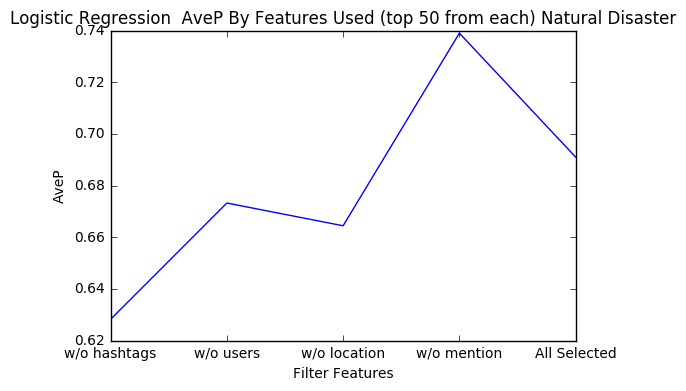

In [7]:
plt.subplot()
plt.plot(nd_aveps)
# add some text for labels, title and axes ticks
plt.ylabel('AveP')
plt.xlabel('Filter Features')
plt.title('Logistic Regression  AveP By Features Used (top 50 from each) Natural Disaster')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

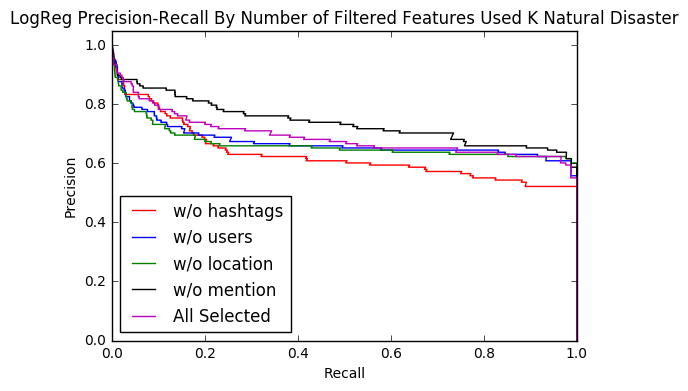

In [8]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')
for i in range(0, len(nd_prec_recall)):
    plt.plot(nd_prec_recall[i][0], nd_prec_recall[i][1], color=colors[i], label=k[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall By Number of Filtered Features Used K Natural Disaster')
plt.show()

It seems that at least for this topic (Natural Disasters) filtering the data without using mentions improves the performance of the classifier. One reason could be that top mention features may not have high coeffecients in comparison to other features.

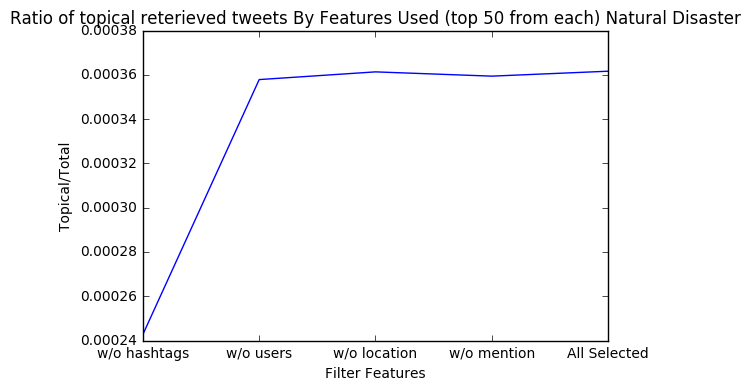

In [11]:
nd_pos_ratio = []
for i in range(0, len(nd_positives)):
    nd_pos_ratio.append(float(nd_positives[i]) / nd_totals[i])
    
plt.subplot()
plt.plot(nd_pos_ratio)
# add some text for labels, title and axes ticks
plt.ylabel('Topical/Total')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Natural Disaster')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

In [12]:
nd_dp = DataPreprocessor(api.get_raw_data())
nd_dp.get_labled_data("Natr_Disaster")
nd_total_topical = nd_dp.get_num_of_positvies()

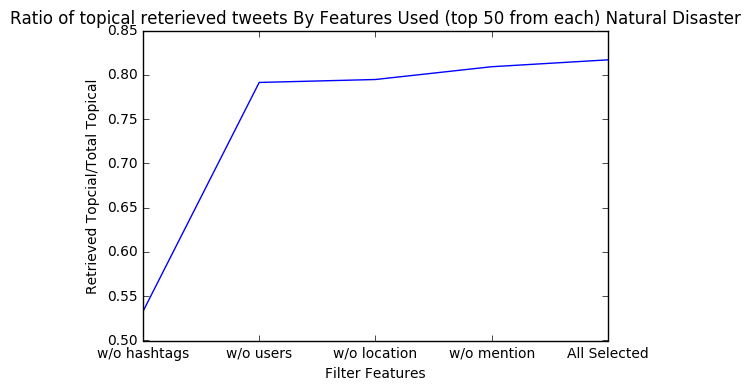

In [14]:
nd_topical_recalled = []
for i in range(0, len(nd_positives)):
    nd_topical_recalled.append(float(nd_positives[i]) / nd_total_topical)

plt.subplot()
plt.plot(nd_topical_recalled)
# add some text for labels, title and axes ticks
plt.ylabel('Retrieved Topcial/Total Topical')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Natural Disaster')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

# Testing Filtering Performance Across Different Topics

I select 2 additional topics: Soccer and Social Issues to check if the results are similar across topics.

In [6]:
topics = ["Natr_Disaster", "Soccer", "Social_issue"]

### Soccer

In [15]:
soccer_tf = TestFramework(api, "Soccer")
soccer_positives, soccer_totals, soccer_pipelines, soccer_aveps, soccer_prec_recall = soccer_tf.run_configs(configs)

Initializing Classifier....
Complete!


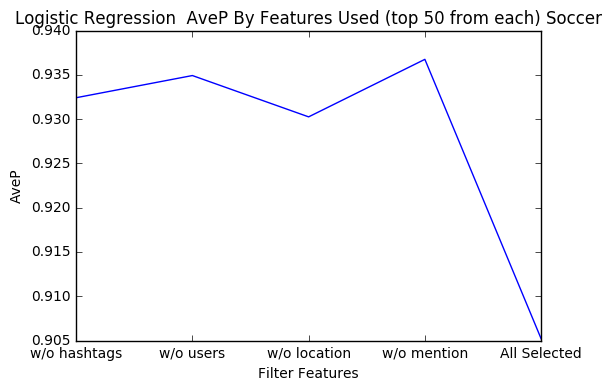

In [17]:
plt.subplot()
plt.plot(soccer_aveps)
# add some text for labels, title and axes ticks
plt.ylabel('AveP')
plt.xlabel('Filter Features')
plt.title('Logistic Regression  AveP By Features Used (top 50 from each) Soccer')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

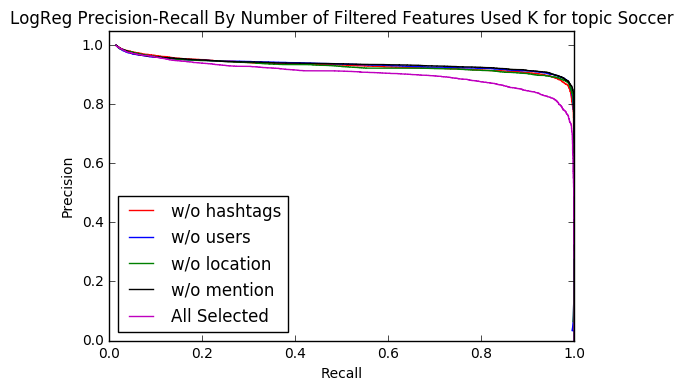

In [18]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')
for i in range(0, len(soccer_prec_recall)):
    plt.plot(soccer_prec_recall[i][0], soccer_prec_recall[i][1], color=colors[i], label=k[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall By Number of Filtered Features Used K for topic Soccer')
plt.show()

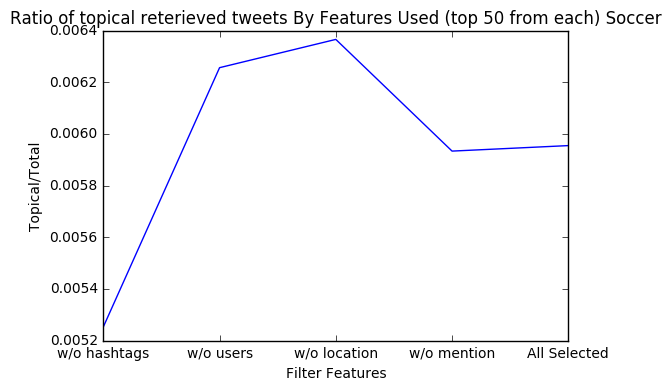

In [19]:
soccer_pos_ratio = []
for i in range(0, len(soccer_positives)):
    soccer_pos_ratio.append(float(soccer_positives[i]) / soccer_totals[i])
    
plt.subplot()
plt.plot(soccer_pos_ratio)
# add some text for labels, title and axes ticks
plt.ylabel('Topical/Total')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Soccer')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

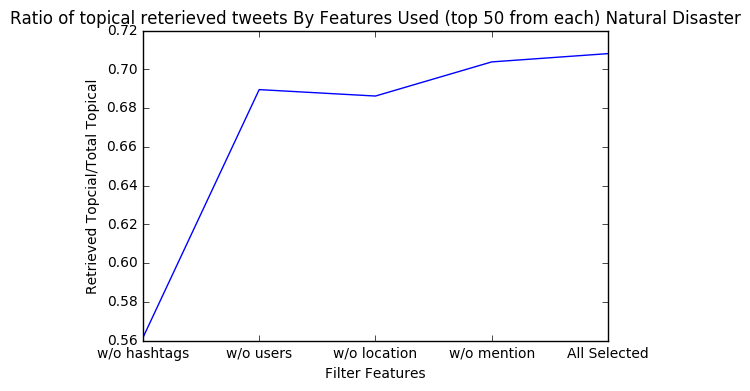

In [20]:
soccer_dp = DataPreprocessor(api.get_raw_data())
soccer_dp.get_labled_data("Soccer")
soccer_total_topical = soccer_dp.get_num_of_positvies()

soccer_topical_recalled = []
for i in range(0, len(soccer_positives)):
    soccer_topical_recalled.append(float(soccer_positives[i]) / soccer_total_topical)

plt.subplot()
plt.plot(soccer_topical_recalled)
# add some text for labels, title and axes ticks
plt.ylabel('Retrieved Topcial/Total Topical')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Soccer')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

### Social Issues

In [8]:
soc_tf = TestFramework(api, "Social_issue")
soc_positives, soc_totals, soc_pipelines, soc_aveps, soc_prec_recall = soc_tf.run_configs(configs)

Initializing Classifier....
Complete!


In [ ]:
plt.subplot()
plt.plot(soc_aveps)
# add some text for labels, title and axes ticks
plt.ylabel('AveP')
plt.xlabel('Filter Features')
plt.title('Logistic Regression  AveP By Features Used (top 50 from each) Social Issues')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

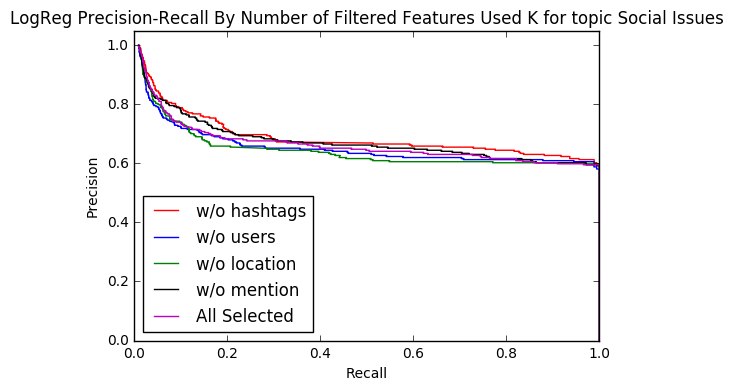

In [22]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')
for i in range(0, len(soc_prec_recall)):
    plt.plot(soc_prec_recall[i][0], soc_prec_recall[i][1], color=colors[i], label=k[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall By Number of Filtered Features Used K for topic Social Issues')
plt.show()

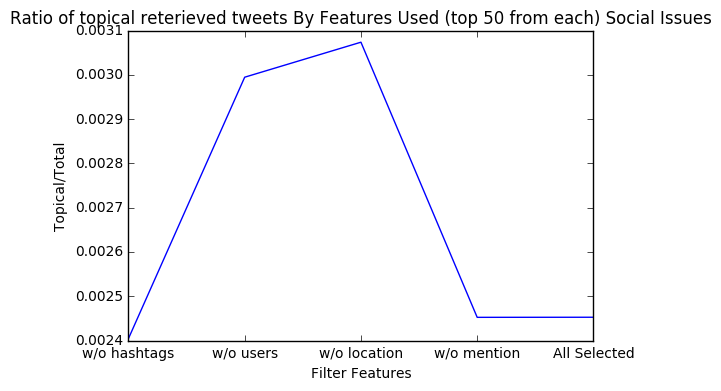

In [23]:
soc_pos_ratio = []
for i in range(0, len(soc_positives)):
    soc_pos_ratio.append(float(soc_positives[i]) / soc_totals[i])
    
plt.subplot()
plt.plot(soc_pos_ratio)
# add some text for labels, title and axes ticks
plt.ylabel('Topical/Total')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Social Issues')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

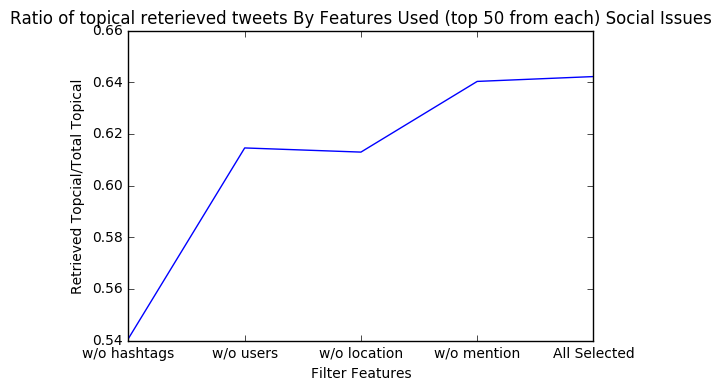

In [9]:
soc_dp = DataPreprocessor(api.get_raw_data())
soc_dp.get_labled_data("Social_issue")
soc_total_topical = soc_dp.get_num_of_positvies()

soc_topical_recalled = []
for i in range(0, len(soc_positives)):
    soc_topical_recalled.append(float(soc_positives[i]) / soc_total_topical)

plt.subplot()
plt.plot(soc_topical_recalled)
# add some text for labels, title and axes ticks
plt.ylabel('Retrieved Topcial/Total Topical')
plt.xlabel('Filter Features')
plt.title('Ratio of topical reterieved tweets By Features Used (top 50 from each) Social Issues')
plt.xticks(np.arange(5), ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected'))
plt.show()

One thing that is consistent across the three topics is that removing mentions from filtering improves the performance. 